# Transformer Part 2: 注意力机制

本notebook实现Transformer中的核心组件：缩放点积注意力机制（Scaled Dot-Product Attention）和多头注意力（Multi-Head Attention）。

基于论文《Attention Is All You Need》中的公式：

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

In [2]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1. 缩放点积注意力 (Scaled Dot-Product Attention)

这是Transformer中最核心的注意力机制。

**数学公式**：

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

其中：
- $Q$ (Query): 查询向量
- $K$ (Key): 键向量
- $V$ (Value): 值向量
- $d_k$: 键向量的维度

**缩放因子** $\sqrt{d_k}$ 的作用：
- 防止点积值过大导致softmax梯度消失
- 保持梯度稳定

In [3]:
def scaled_dot_product_attention(Q, K, V, mask=None, dropout=None):
    """
    计算缩放点积注意力
    
    参数:
        Q: 查询张量，形状为 (batch_size, n_heads, seq_len, d_k)
        K: 键张量，形状为 (batch_size, n_heads, seq_len, d_k)
        V: 值张量，形状为 (batch_size, n_heads, seq_len, d_v)
        mask: 掩码张量，形状为 (batch_size, 1, seq_len, seq_len)
        dropout: dropout层
    
    返回:
        output: 注意力输出，形状为 (batch_size, n_heads, seq_len, d_v)
        attention_weights: 注意力权重，形状为 (batch_size, n_heads, seq_len, seq_len)
    """
    # 获取维度信息
    d_k = Q.size(-1)
    
    # 计算注意力分数: QK^T / sqrt(d_k)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    # 应用掩码（如果有）
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 应用softmax得到注意力权重
    attention_weights = F.softmax(scores, dim=-1)
    
    # 应用dropout（如果有）
    if dropout is not None:
        attention_weights = dropout(attention_weights)
    
    # 计算输出：注意力权重 × V
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

## 2. 多头注意力 (Multi-Head Attention)

多头注意力允许模型同时关注不同位置的不同表示子空间的信息。

**数学公式**：

$$MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O$$

其中：
- $head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$
- $W_i^Q, W_i^K, W_i^V, W^O$ 是线性变换矩阵

In [4]:
class MultiHeadAttention(nn.Module):
    """
    多头注意力机制实现
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        dropout: dropout概率
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        # 确保d_model能被n_heads整除
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # 每个头的维度
        
        # 线性变换层
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def split_heads(self, x):
        """
        将输入张量分割成多个注意力头
        
        参数:
            x: 输入张量，形状为 (batch_size, seq_len, d_model)
        
        返回:
            分割后的张量，形状为 (batch_size, n_heads, seq_len, d_k)
        """
        batch_size, seq_len, d_model = x.size()
        
        # 重塑张量: (batch_size, seq_len, d_model) -> (batch_size, seq_len, n_heads, d_k)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        
        # 转置: (batch_size, seq_len, n_heads, d_k) -> (batch_size, n_heads, seq_len, d_k)
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        """
        将多个注意力头的输出合并
        
        参数:
            x: 多头输出，形状为 (batch_size, n_heads, seq_len, d_k)
        
        返回:
            合并后的张量，形状为 (batch_size, seq_len, d_model)
        """
        batch_size, n_heads, seq_len, d_k = x.size()
        
        # 转置: (batch_size, n_heads, seq_len, d_k) -> (batch_size, seq_len, n_heads, d_k)
        x = x.transpose(1, 2)
        
        # 重塑: (batch_size, seq_len, n_heads, d_k) -> (batch_size, seq_len, d_model)
        return x.contiguous().view(batch_size, seq_len, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        """
        多头注意力的前向传播
        
        参数:
            query: 查询张量，形状为 (batch_size, seq_len, d_model)
            key: 键张量，形状为 (batch_size, seq_len, d_model)
            value: 值张量，形状为 (batch_size, seq_len, d_model)
            mask: 掩码张量，形状为 (batch_size, 1, seq_len, seq_len)
        
        返回:
            output: 注意力输出，形状为 (batch_size, seq_len, d_model)
            attention_weights: 注意力权重，形状为 (batch_size, n_heads, seq_len, seq_len)
        """
        batch_size = query.size(0)
        
        # 线性变换
        Q = self.W_Q(query)
        K = self.W_K(key)
        V = self.W_V(value)
        
        # 分割成多个头
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # 计算缩放点积注意力
        attention_output, attention_weights = scaled_dot_product_attention(
            Q, K, V, mask=mask, dropout=self.dropout
        )
        
        # 合并多个头
        output = self.combine_heads(attention_output)
        
        # 最终线性变换
        output = self.W_O(output)
        
        return output, attention_weights

## 3. 创建掩码函数

在Transformer中，我们需要两种类型的掩码：
1. **Padding掩码**：屏蔽padding token，防止它们影响注意力计算
2. **前瞻掩码（Look-ahead mask）**：在解码器中防止看到未来的信息

In [5]:
def create_padding_mask(seq, pad_idx=0):
    """
    创建padding掩码
    
    参数:
        seq: 输入序列，形状为 (batch_size, seq_len)
        pad_idx: padding token的索引
    
    返回:
        mask: 掩码张量，形状为 (batch_size, 1, 1, seq_len)
    """
    # 创建掩码：非padding位置为1，padding位置为0
    mask = (seq != pad_idx).unsqueeze(1).unsqueeze(2)
    return mask

def create_look_ahead_mask(size):
    """
    创建前瞻掩码（下三角矩阵）
    
    参数:
        size: 序列长度
    
    返回:
        mask: 下三角矩阵，形状为 (1, size, size)
    """
    # 创建下三角矩阵
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask == 0  # 反转：下三角为1，上三角为0

## 4. 测试注意力机制

In [6]:
def test_attention():
    """
    测试注意力机制的实现
    """
    print("测试注意力机制...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    n_heads = 8
    
    # 创建多头注意力层
    mha = MultiHeadAttention(d_model, n_heads)
    
    # 创建测试输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output, attention_weights = mha(x, x, x)
    
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {output.shape}")
    print(f"注意力权重形状: {attention_weights.shape}")
    
    # 验证输出形状
    assert output.shape == (batch_size, seq_len, d_model), f"输出形状错误: {output.shape}"
    assert attention_weights.shape == (batch_size, n_heads, seq_len, seq_len), f"注意力权重形状错误"
    
    print("✓ 形状测试通过")
    print(f"输出数值范围: [{output.min().item():.3f}, {output.max().item():.3f}]")
    
    # 测试掩码功能
    print("\n测试掩码功能...")
    
    # 创建padding掩码
    seq = torch.tensor([[1, 2, 3, 0, 0], [1, 2, 3, 4, 0]])  # 0是padding
    padding_mask = create_padding_mask(seq)
    print(f"Padding掩码形状: {padding_mask.shape}")
    print(f"Padding掩码: {padding_mask.squeeze()}")
    
    # 创建前瞻掩码
    look_ahead_mask = create_look_ahead_mask(seq_len)
    print(f"前瞻掩码形状: {look_ahead_mask.shape}")
    print(f"前瞻掩码: {look_ahead_mask.squeeze()}")
    
    # 使用掩码进行注意力计算
    masked_output, masked_attention = mha(x, x, x, mask=padding_mask)
    print(f"带掩码的输出形状: {masked_output.shape}")
    
    print("✓ 注意力机制测试完成")
    
    return output, attention_weights

# 运行测试
output, attention_weights = test_attention()

测试注意力机制...
输入形状: torch.Size([2, 10, 512])
输出形状: torch.Size([2, 10, 512])
注意力权重形状: torch.Size([2, 8, 10, 10])
✓ 形状测试通过
输出数值范围: [-0.505, 0.441]

测试掩码功能...
Padding掩码形状: torch.Size([2, 1, 1, 5])
Padding掩码: tensor([[ True,  True,  True, False, False],
        [ True,  True,  True,  True, False]])
前瞻掩码形状: torch.Size([10, 10])
前瞻掩码: tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  T

RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 3

## 5. 注意力权重可视化

可视化注意力权重...


e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 22836 (\N{CJK UNIFIED IDEOGRAPH-5934}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarn

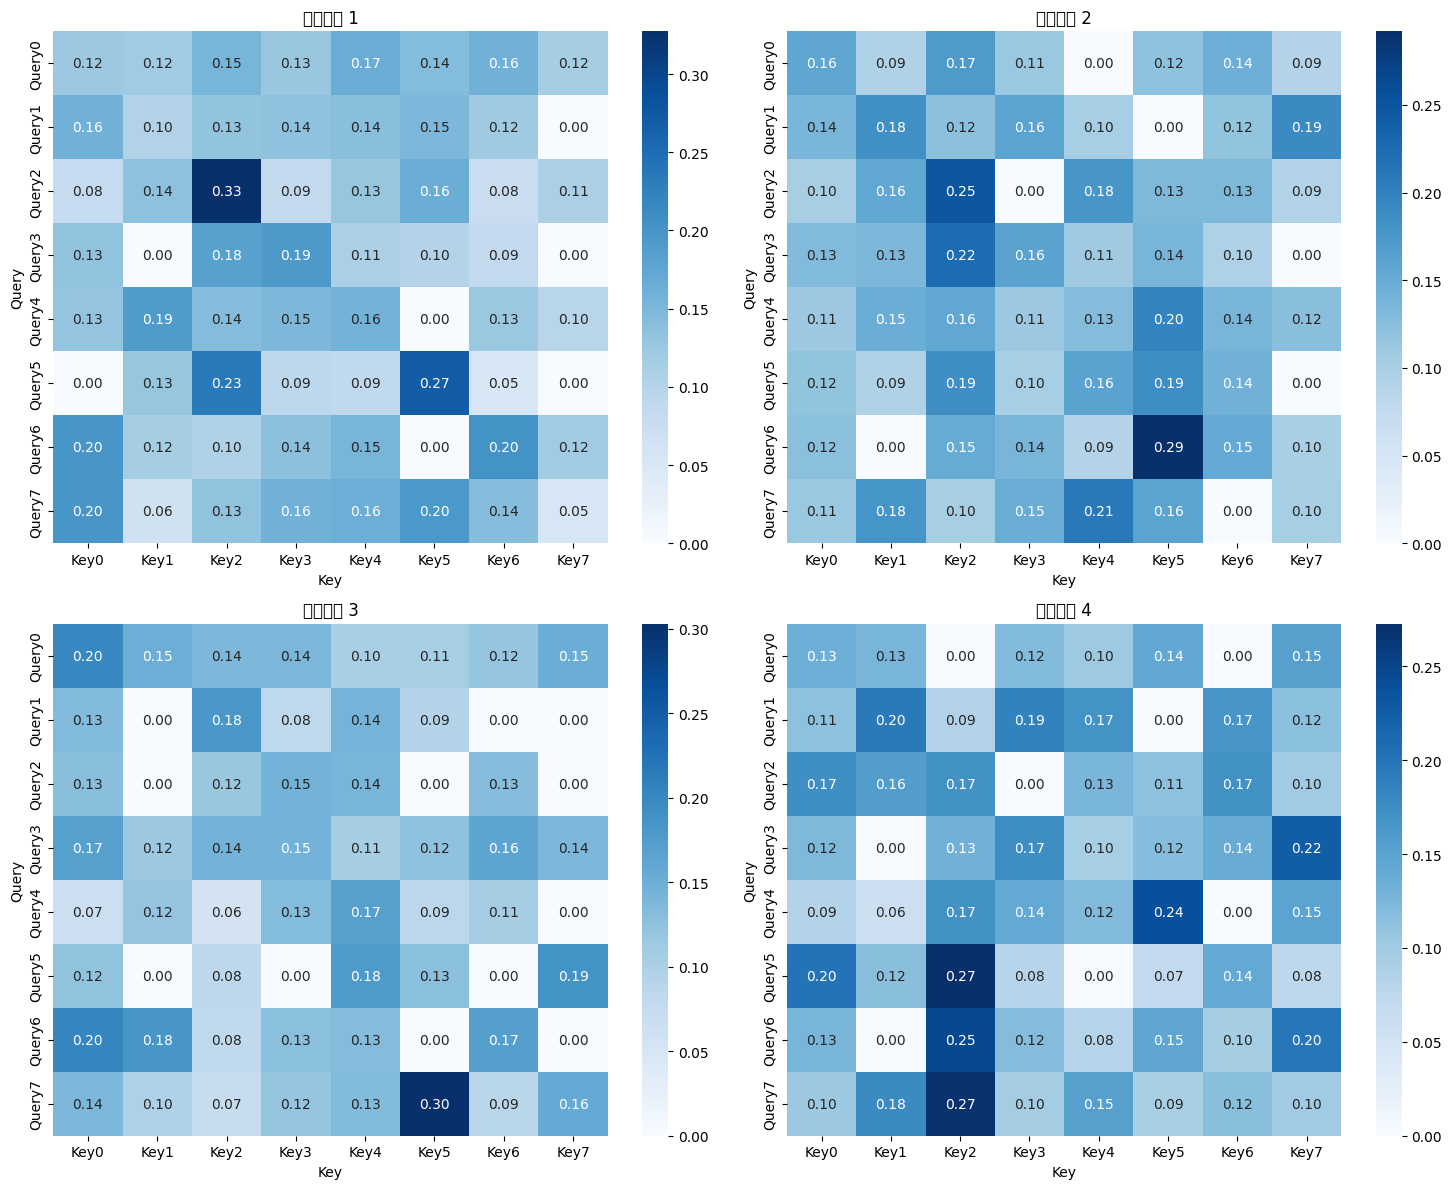

e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Application\Anaconda\envs\llm\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAP

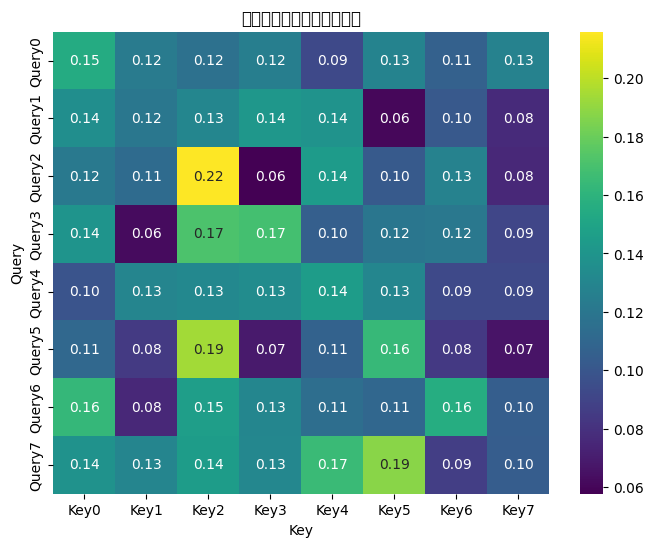

✓ 注意力权重可视化完成
注意力权重形状: torch.Size([1, 4, 8, 8])
平均注意力权重最大值: 0.216
平均注意力权重最小值: 0.058


In [7]:
def visualize_attention_weights():
    """
    可视化注意力权重，帮助理解注意力机制
    """
    print("可视化注意力权重...")
    
    # 参数设置
    batch_size = 1
    seq_len = 8
    d_model = 256
    n_heads = 4
    
    # 创建简单的输入序列
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 创建多头注意力层
    mha = MultiHeadAttention(d_model, n_heads)
    
    # 获取注意力权重
    output, attention_weights = mha(x, x, x)
    
    # 绘制注意力权重热力图
    plt.figure(figsize=(15, 12))
    
    # 绘制每个注意力头的权重
    for head in range(n_heads):
        plt.subplot(2, n_heads//2, head+1)
        
        # 获取当前头的注意力权重
        head_weights = attention_weights[0, head].detach().numpy()
        
        # 绘制热力图
        sns.heatmap(head_weights, 
                 annot=True, 
                 fmt='.2f', 
                 cmap='Blues',
                 xticklabels=[f'Key{i}' for i in range(seq_len)],
                 yticklabels=[f'Query{i}' for i in range(seq_len)])
        
        plt.title(f'注意力头 {head+1}')
        plt.xlabel('Key')
        plt.ylabel('Query')
    
    plt.tight_layout()
    plt.show()
    
    # 绘制平均注意力权重
    plt.figure(figsize=(8, 6))
    avg_weights = attention_weights.mean(dim=1)[0].detach().numpy()  # 平均所有头
    
    sns.heatmap(avg_weights, 
               annot=True, 
               fmt='.2f', 
               cmap='viridis',
               xticklabels=[f'Key{i}' for i in range(seq_len)],
               yticklabels=[f'Query{i}' for i in range(seq_len)])
    
    plt.title('平均注意力权重（所有头）')
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.show()
    
    print("✓ 注意力权重可视化完成")
    print(f"注意力权重形状: {attention_weights.shape}")
    print(f"平均注意力权重最大值: {avg_weights.max():.3f}")
    print(f"平均注意力权重最小值: {avg_weights.min():.3f}")

# 运行可视化
visualize_attention_weights()

## 6. 不同掩码模式对比

对比不同掩码模式...


e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26080 (\N{CJK UNIFIED IDEOGRAPH-65E0}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarn

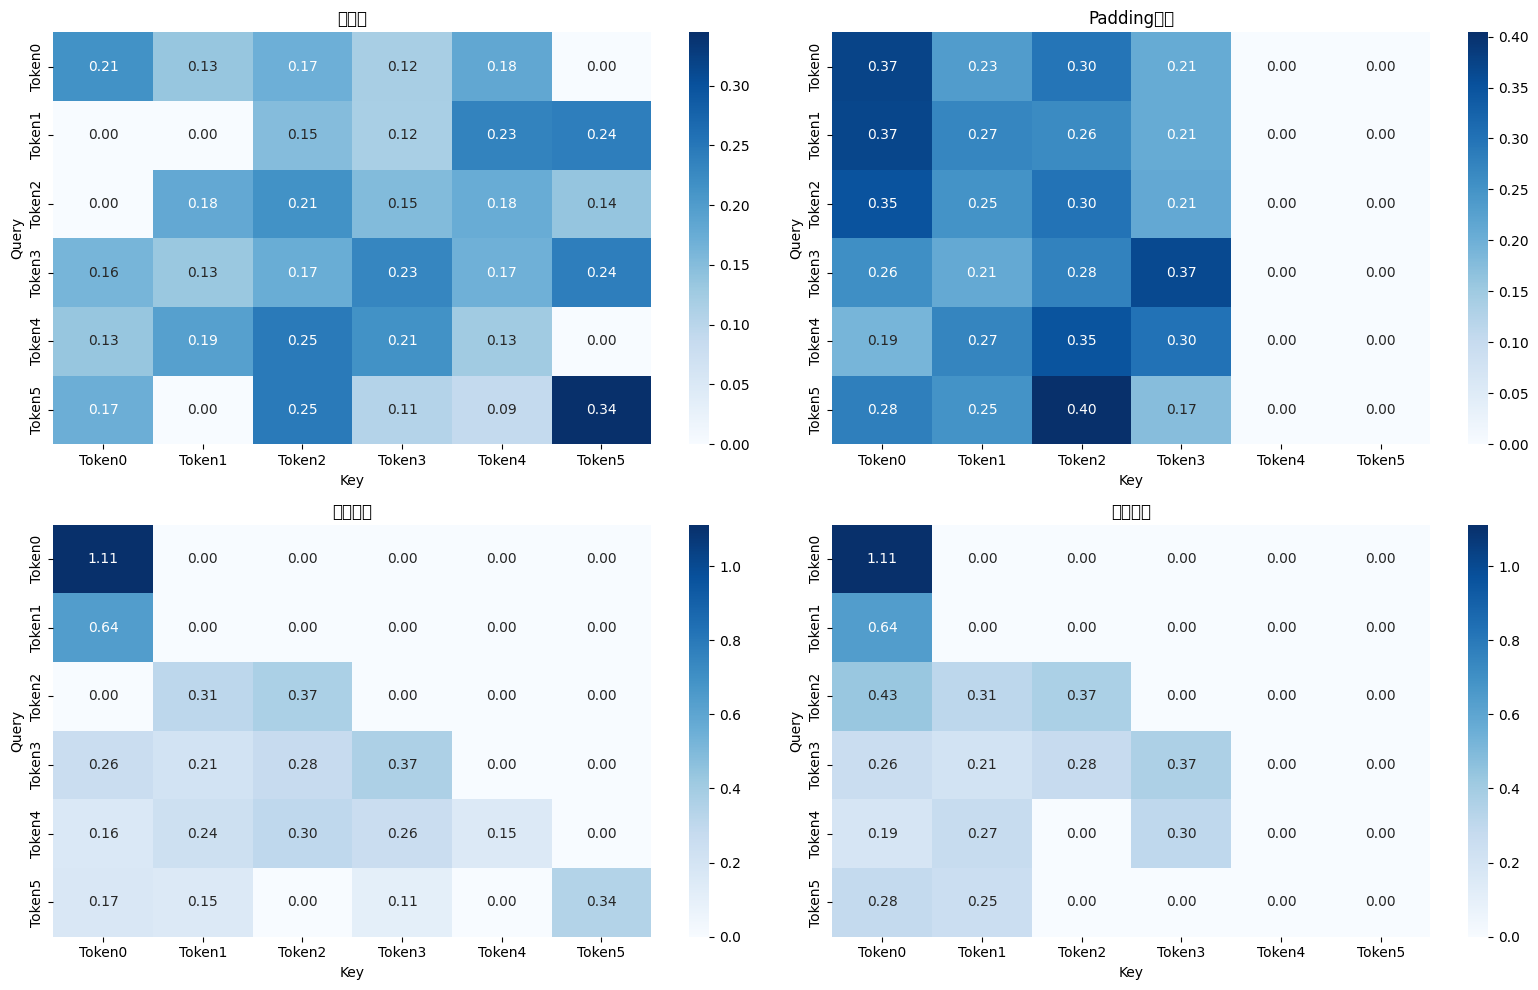

✓ 掩码模式对比完成
观察要点：
- 无掩码：所有位置都可以关注所有位置
- Padding掩码：padding位置（最后两个）被屏蔽
- 前瞻掩码：只能关注当前位置及之前的位置
- 组合掩码：结合padding和前瞻掩码的效果


In [8]:
def compare_mask_patterns():
    """
    对比不同掩码模式对注意力权重的影响
    """
    print("对比不同掩码模式...")
    
    # 参数设置
    batch_size = 1
    seq_len = 6
    d_model = 256
    n_heads = 1  # 使用单头便于观察
    
    # 创建输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 创建多头注意力层
    mha = MultiHeadAttention(d_model, n_heads)
    
    # 不同的掩码模式
    masks = {
        '无掩码': None,
        'Padding掩码': create_padding_mask(torch.tensor([[1, 2, 3, 4, 0, 0]])),
        '前瞻掩码': create_look_ahead_mask(seq_len).unsqueeze(0).unsqueeze(0),
        '组合掩码': create_padding_mask(torch.tensor([[1, 2, 3, 4, 0, 0]])) & 
                   create_look_ahead_mask(seq_len).unsqueeze(0).unsqueeze(0)
    }
    
    plt.figure(figsize=(16, 10))
    
    for i, (mask_name, mask) in enumerate(masks.items()):
        # 使用掩码进行注意力计算
        output, attention_weights = mha(x, x, x, mask=mask)
        
        # 绘制注意力权重
        plt.subplot(2, 2, i+1)
        weights = attention_weights[0, 0].detach().numpy()
        
        sns.heatmap(weights, 
                   annot=True, 
                   fmt='.2f', 
                   cmap='Blues',
                   xticklabels=[f'Token{i}' for i in range(seq_len)],
                   yticklabels=[f'Token{i}' for i in range(seq_len)])
        
        plt.title(f'{mask_name}')
        plt.xlabel('Key')
        plt.ylabel('Query')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ 掩码模式对比完成")
    print("观察要点：")
    print("- 无掩码：所有位置都可以关注所有位置")
    print("- Padding掩码：padding位置（最后两个）被屏蔽")
    print("- 前瞻掩码：只能关注当前位置及之前的位置")
    print("- 组合掩码：结合padding和前瞻掩码的效果")

# 运行对比
compare_mask_patterns()

## 7. 与PyTorch官方实现对比

In [9]:
def compare_with_pytorch_mha():
    """
    与PyTorch官方MultiheadAttention实现进行对比
    """
    print("与PyTorch官方MultiheadAttention对比...")
    
    try:
        # 导入PyTorch官方实现
        from torch.nn import MultiheadAttention as PyTorchMHA
        
        # 参数设置
        batch_size = 2
        seq_len = 10
        d_model = 512
        n_heads = 8
        
        # 创建两种实现
        our_mha = MultiHeadAttention(d_model, n_heads)
        pytorch_mha = PyTorchMHA(d_model, n_heads, batch_first=True)
        
        # 创建测试输入
        x = torch.randn(batch_size, seq_len, d_model)
        
        # 我们的实现
        our_output, our_attention = our_mha(x, x, x)
        
        # PyTorch官方实现
        pytorch_output, pytorch_attention = pytorch_mha(x, x, x)
        
        print("✓ 两种实现都能正常工作")
        print(f"我们的实现输出形状: {our_output.shape}")
        print(f"PyTorch实现输出形状: {pytorch_output.shape}")
        
        # 对比数值范围
        print(f"我们的实现数值范围: [{our_output.min().item():.3f}, {our_output.max().item():.3f}]")
        print(f"PyTorch实现数值范围: [{pytorch_output.min().item():.3f}, {pytorch_output.max().item():.3f}]")
        
        # 计算差异
        diff = torch.abs(our_output - pytorch_output).mean().item()
        print(f"平均绝对差异: {diff:.6f}")
        
        if diff < 0.1:
            print("✓ 两种实现非常接近")
        else:
            print("⚠ 两种实现存在较大差异")
        
    except ImportError:
        print("PyTorch版本不支持MultiheadAttention，跳过对比")
    except Exception as e:
        print(f"对比过程中出现错误: {e}")
    
    print("✓ 对比测试完成")

# 运行对比
compare_with_pytorch_mha()

与PyTorch官方MultiheadAttention对比...
✓ 两种实现都能正常工作
我们的实现输出形状: torch.Size([2, 10, 512])
PyTorch实现输出形状: torch.Size([2, 10, 512])
我们的实现数值范围: [-0.410, 0.460]
PyTorch实现数值范围: [-0.499, 0.506]
平均绝对差异: 0.148415
⚠ 两种实现存在较大差异
✓ 对比测试完成


## 8. 总结

在这个notebook中，我们实现了Transformer的核心注意力机制：

### 1. 缩放点积注意力
- **公式**: $Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$
- **关键**: 使用$\sqrt{d_k}$缩放防止梯度消失

### 2. 多头注意力
- **优势**: 允许模型同时关注不同位置的不同表示子空间
- **实现**: 将d_model维度分割成多个头，分别计算注意力

### 3. 掩码机制
- **Padding掩码**: 屏蔽padding token，防止影响计算
- **前瞻掩码**: 在解码时防止看到未来信息

### 关键洞察：
1. 注意力权重表示查询与键之间的相关性
2. 多头机制让模型能捕捉不同类型的关系
3. 掩码确保模型按预期方式工作

### 下一步：

接下来我们将实现层归一化（Layer Normalization），这是Transformer中的另一个重要组件。